#### Loading data

In [4]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/seBrainSim.RData")
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree.RData")
load("environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/updated/comp_trees/trMCorUPGMA.RData")
load("environment/brain_sim_nodtu/mode=gc_bias/mapDf.RData")

In [5]:
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(dplyr))
trees <- read.tree("/fs/cbcb-lab/rob/students/noor/Uncertainity/terminus/1_1/group_nwk.txt")

In [6]:
length(trees)
table(sapply(trees, function(tree) length(tree$tip)))
sum(sapply(trees, function(tree) length(tree$tip)))

[1] 21820


    2     3     4     5     6     7     8     9    10    11    12    13    14 
11531  4098  2250  1298   774   597   382   216   168   130    93    61    45 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
   31    33    21    16     8    13     8     9     4     6     5     1     5 
   28    31    32    34    36    37    39    42    47    58    60    61 
    3     2     2     1     1     1     1     1     1     2     1     1 

[1] 73938

The number of transcripts covered by mean inf reduction is 73938 compared to 122K covered by consensus. For consensus tree after correcting for other transcripts that would have been missed we 129K txps

In [3]:
gold_col <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/terminus/1_1/golden_collapses.log", header = F)
oth_col <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/terminus/1_1/collapsed.log",header = F)

In [13]:
head(oth_col)

,V1,V2,V3,V4,V5
,<int>,<int>,<dbl>,<dbl>,<dbl>
1,64100,64101,695.2826,454.40789,-518.8135
2,190627,190628,359.8111,367.75871,-363.7059
3,103850,103851,349.5727,319.27274,-334.2395
4,124062,124063,189.5785,384.64022,-258.6980
5,32115,32116,329.6591,58.07966,-193.7927
6,126071,126072,105.0655,281.00099,-192.5627


In [14]:
head(gold_col)

,V1,V2,V3,V4
,<int>,<int>,<dbl>,<dbl>
1,135347,135348,0.2092018,0.1950577
2,198385,199278,79.7003465,73.0272890
3,198383,199276,27.7232060,27.5037076
4,198379,199272,27.6885216,27.7430379
5,144668,144673,17.0534941,17.1025386
6,145377,145440,0.5584797,0.6442223


### Testing infRV reduction

In [28]:
i <- 1
oth_col$V1[i] %in% union(gold_col$V1, gold_col$V1) | oth_col$V2[i] %in% union(gold_col$V1, gold_col$V1)

[1] FALSE

In [22]:
source("brain_simulation_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree_analysis/tree_filter.R")

In [23]:
infRV <- computeInfRV(yNS, subOne = T)

In [34]:
infReps <- assays(yNS)[grep("infRep", assayNames(yNS))]
infReps <- abind::abind(as.list(infReps), along = 3)


[1] NA NA

In [50]:
for(i in seq(6)) {
        m <- colSums(infReps[c(mapDf[oth_col$V1[i]+1,2], mapDf[oth_col$V2[i]+1,2]),,])
        means <- rowMeans(m)-1
        vars <- rowVars(m)
        print(mean(pmax(vars-means,0)/(means+5)+0.01 - rowMeans(cbind(infRV$infRV[mapDf[oth_col$V1[i]+1,2],],infRV$infRV[mapDf[oth_col$V2[i]+1,2],]))))
}


[1] -518.8135
[1] -363.7059
[1] -334.2395
[1] -258.698
[1] -193.7927
[1] -192.5627


### Extracting tree and conversion

#### ToDo
~~Create a new yNS, which is union of all transcripts ~~<br>
~~Accordingly adjust trees and genes for the remaining transcripts~~<br>
Find the overlap between consensus and mean inf reduction trees<br>
~~Weighted logFC~~<br>
~~nGenes~~<br>
~~Net reduction in infRV where there is reduction ~~<br>
Understand the impact of code in main branch (act_source and target)
infRV related metrics 

In [41]:
treeMC <- mergeTree(trees, se = mapDf)
se <- scaleInfReps(seBrainSim)
se <- labelKeep(se)
totalTxps <- union(treeMC$tip, tree$tip)
mb <- mergeLeaves(treeMC, se[totalTxps,])
treeMC <- mb[["tree"]]
yMeanInf <- mb[["ySwish"]]
rm(mb)
gc()
yMeanInf <- runSwishtree(treeMC, yMeanInf, type = "union")
sum(rownames(yMeanInf) != treeMC$tip)

yAggMeanInf <- prepSwish(treeMC, yMeanInf)

yMeanInfNS <- seBrainSim[treeMC$tip,]
yMeanInfNS <- computeInfRV(yMeanInfNS, meanVariance=F)
mcols(yMeanInf)[["meanInfRV"]] <- mcols(yMeanInfNS)[["meanInfRV"]]

yAggMeanInfNS <- prepSwish(treeMC, yMeanInfNS)
yAggMeanInfNS <- computeInfRV(yAggMeanInfNS, meanVariance=F)
mcols(yAggMeanInf)[["meanInfRV"]] <- mcols(yAggMeanInfNS)[["meanInfRV"]]

[1] "Missing txps 55760"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10640865,568.3,20779724,1109.8,20779724,1109.8
Vcells,1558210100,11888.2,2590550024,19764.4,2590549550,19764.4


[1] 0

In [40]:
save(treeMC, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/treeMC.RData")
save(yMeanInf, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yMeanInf.RData")
save(yMeanInfNS, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yMeanInfNS.RData")
save(yAggMeanInf, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yAggMeanInf.RData")
save(yAggMeanInfNS, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yAggMeanInfNS.RData")

### Consensus tree

In [50]:
mb <- mergeLeaves(tree, se[totalTxps,])
treeCons <- mb[["tree"]]
yCons <- mb[["ySwish"]]
rm(mb)
gc()
sum(treeCons$tip != rownames(yCons))
yCons <- runSwishTree(treeCons, yCons, type = "union")
yAggCons <- prepSwish(treeCons, yCons)

yConsNS <- seBrainSim[treeCons$tip,]
yConsNS <- computeInfRV(yConsNS, meanVariance=F)
mcols(yCons)[["meanInfRV"]] <- mcols(yConsNS)[["meanInfRV"]]

yAggConsNS <- prepSwish(treeCons, yConsNS)
yAggConsNS <- computeInfRV(yAggConsNS, meanVariance=F)
mcols(yAggCons)[["meanInfRV"]] <- mcols(yAggConsNS)[["meanInfRV"]]

[1] "Missing txps 93"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10644444,568.5,20779724,1109.8,20779724,1109.8
Vcells,2159837503,16478.3,3730568033,28462.0,3730561657,28462.0


[1] 0

In [ ]:
save(treeCons, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/treeCons.RData")
save(yCons, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yCons.RData")
save(yConsNS, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yConsNS.RData")
save(yAggCons, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yAggCons.RData")
save(yAggConsNS, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yAggConsNS.RData")

###  Correlation tree

In [14]:
sum(!trMeanCorUPGMA$tip %in% totalTxps)==0
mb <- mergeLeaves(trMeanCorUPGMA, se[totalTxps,])
treeCor <- mb[["tree"]]
yCor <- mb[["ySwish"]]
rm(mb)
gc()
sum(treeCor$tip != rownames(yCor)) == 0
yCor <- runSwishTree(treeCor, yCor, type = "union")
yAggCor <- prepSwish(treeCor, yCor)

yCorNS <- seBrainSim[treeCor$tip,]
yCorNS <- computeInfRV(yCorNS, meanVariance=F)
mcols(yCor)[["meanInfRV"]] <- mcols(yCorNS)[["meanInfRV"]]

yAggCorNS <- prepSwish(treeCor, yCorNS)
yAggCorNS <- computeInfRV(yConsNS, meanVariance=F)
mcols(yAggCor)[["meanInfRV"]] <- mcols(yAggCorNS)[["meanInfRV"]]

[1] TRUE

[1] "Missing txps 93"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10566497,564.4,20688381,1104.9,20688381,1104.9
Vcells,703508666,5367.4,1090415710,8319.3,1090413035,8319.2


[1] TRUE

In [23]:
yAggCorNS <- prepSwish(treeCor, yCorNS)
yAggCorNS <- computeInfRV(yAggCorNS, meanVariance=F)
mcols(yAggCor)[["meanInfRV"]] <- mcols(yAggCorNS)[["meanInfRV"]]

In [20]:
yAggCorNS <- computeInfRV(yAggCorNS, meanVariance=F)
mcols(yAggCor)[["meanInfRV"]] <- mcols(yAggCorNS)[["meanInfRV"]]

In [22]:
save(treeCor, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/treeCor.RData")
save(yCor, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yCor.RData")
save(yCorNS, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yCorNS.RData")
save(yAggCor, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yAggCor.RData")
save(yAggCorNS, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/yAggCorNS.RData")

In [56]:
depth <- node.depth(treeMC, 2)
modDep <- depth
modDep[depth > 6]=7
dfInf <- data.frame(infRV = mcols(yAggSMeanCons)[["meanInfRV"]], depth = modDep)

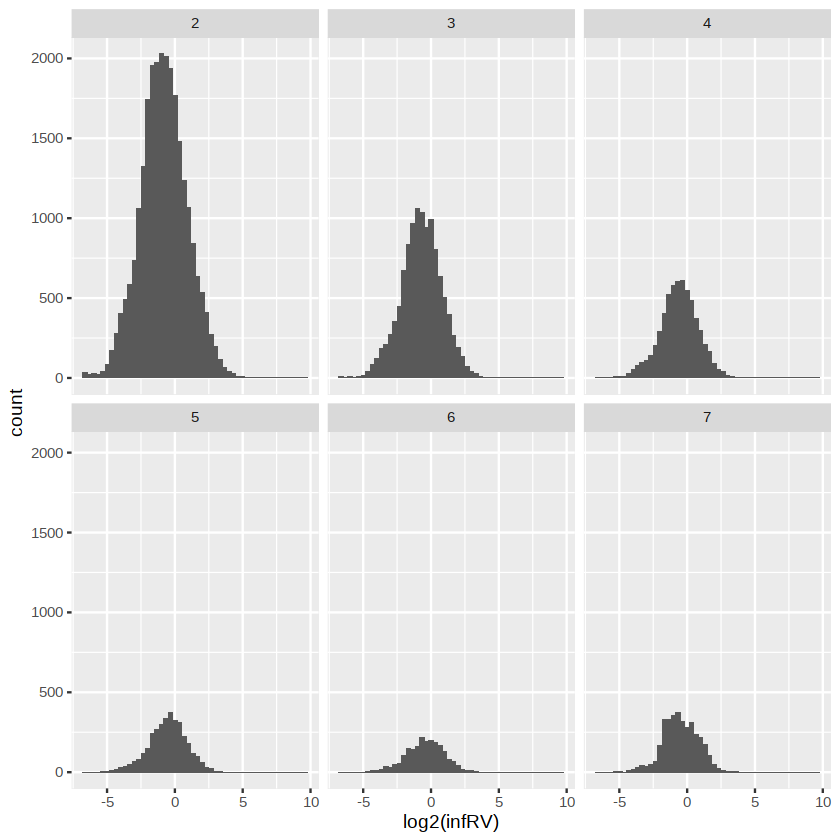

In [63]:
dfInf %>% filter(depth!=1) %>% ggplot(aes(x=log2(infRV))) + geom_histogram(bins=50) + facet_wrap(vars(depth))

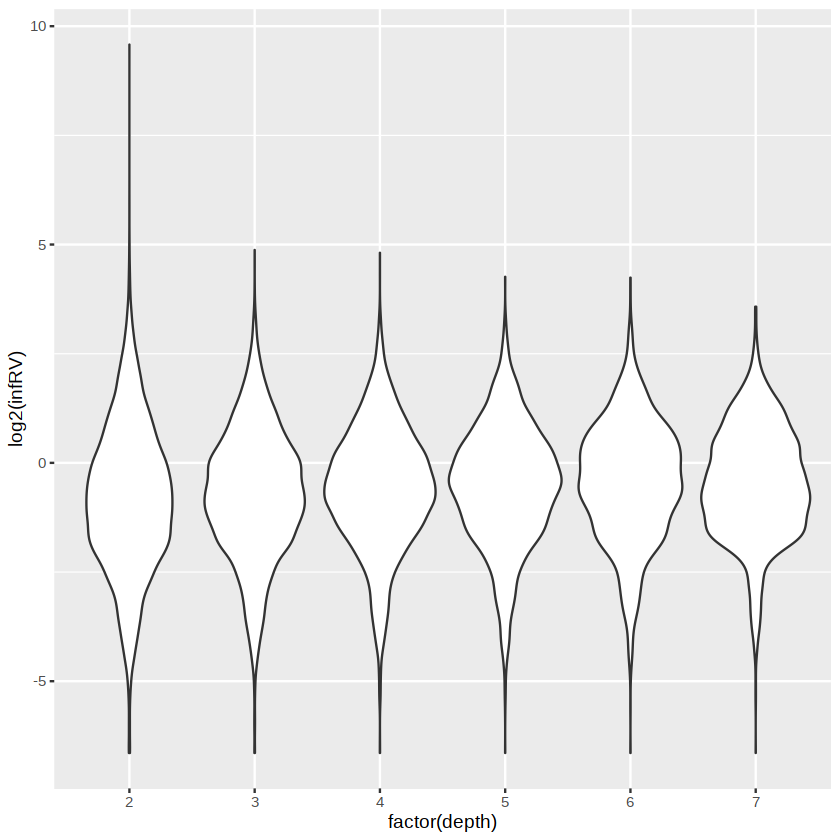

In [68]:
dfInf %>% filter(depth!=1) %>% ggplot(aes(y=log2(infRV), x=factor(depth))) + geom_violin()

In [3]:
load("environment/brain_sim_nodtu/mode=gc_bias/mapDf.RData")

In [24]:
nNodes <- length(treeMC$tip)+treeMC$Nnode
desc <- Descendants(treeMC, seq(nNodes))
genesMeanCons <- mclapply(desc[length(treeMC$tip)+1:treeMC$Nnode], function(txps) unique(mapDf[treeMC$tip[txps],1]), mc.cores=4)
save(genesMeanCons, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/genesMC.RData")

Warning message in mclapply(desc[length(treeMC$tip) + 1:treeMC$Nnode], function(txps) unique(mapDf[treeMC$tip[txps], :
"scheduled cores 1, 3 did not deliver results, all values of the jobs will be affected"


In [8]:
nGenes <- rep(0, nNodes)
nGenes[1:length(treeMC$tip)] <- 1
nGenes[length(treeMC$tip)+1:treeMC$Nnode] <- sapply(genesMeanCons, length)

In [2]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(dplyr))


In [2]:
genesMeanInf <- mclapply(desc[length(treeMC$tip)+1:treeMC$Nnode], function(txps) unique(mapDf[treeMC$tip[txps],1]), mc.cores=4)

In [18]:
save(genesMeanInf, file="environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/mean_cons/genesMeanInf.RData")